# **A2: Bias in Data**
## **Harini Ram Prasad**




# Introduction

For this project, I will be analysing Wikipedia's Talk corpus in order to assess whether it contains possible sources of bias. Specifically, I will limit the scope to the 'Toxicity' and 'Aggression' datasets. This is because both these datasets have been annotated similarly (on scales of -2 to 2, -2 being the most aggressive/toxic and 2 being the least aggressive/toxic). Thus, comparison is made more convenient.

# Importing Libraries (functionality in code comments)

In [206]:
# Data extraction libraries
import urllib
from urllib import request

# Data manipulation libraries
import pandas as pd
import numpy as np

# NLP libraries
import nltk
from nltk.corpus import stopwords
import string # list of punctuation
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords

# Visualization libraries and configurations
import matplotlib.pyplot as plt
% matplotlib inline
from wordcloud import WordCloud

# System libraries
import os
# Making directories for visualizations and data
os.mkdir("Visualizations")
os.mkdir("Data")

# Step 1: Data Extraction and Preparation


Data extraction involves downloading the '[Aggression](https://figshare.com/articles/dataset/Wikipedia_Talk_Labels_Aggression/4267550)' and '[Toxicity](https://figshare.com/articles/dataset/Wikipedia_Talk_Labels_Toxicity/4563973)' datasets from Wikipedia.

The utility function to download the tsv files is provided in the cell below.

In [163]:
def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

First, the annotated Wikipedia comments, annotations and worker demographic data must be downloaded from separate links. In the cell below, the download links are specified and the function call is made to download all 6 files (toxicity_annotated_comments, toxicity_annotations, toxicity_workers ,aggression_annotated_comments, aggression_annotations, aggression_workers).

In [164]:
# links to download annotated comments, annotations, worker demographics

# Links for download
# Toxicity data URLs
TOXIC_ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7394542' 
TOXIC_ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7394539' 
TOXIC_WORKERS_URL = 'https://ndownloader.figshare.com/files/7640581'
# Aggression data URLs
AGGRESSION_ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7038038' 
AGGRESSION_ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7394506' 
AGGRESSION_WORKERS_URL = 'https://ndownloader.figshare.com/files/7640644'

# Function calls for downloading 6 data files
# Toxic downloads
download_file(TOXIC_ANNOTATED_COMMENTS_URL, 'Data/toxicity_annotated_comments.tsv')
download_file(TOXIC_ANNOTATIONS_URL, 'Data/toxicity_annotations.tsv')
download_file(TOXIC_WORKERS_URL, 'Data/toxicity_workers.tsv')
# Aggression downloads
download_file(AGGRESSION_ANNOTATED_COMMENTS_URL, 'Data/aggression_annotated_comments.tsv')
download_file(AGGRESSION_ANNOTATIONS_URL, 'Data/aggression_annotations.tsv')
download_file(AGGRESSION_WORKERS_URL, 'Data/aggression_workers.tsv')

The cell below converts the downloaded tsv files to pandas dataframes.

In [165]:
# Aggression dataset files from tsv to pandas dataframes
aggression_comments = pd.read_csv('Data/aggression_annotated_comments.tsv', sep = '\t', index_col = 0)
aggression_annotations = pd.read_csv('Data/aggression_annotations.tsv',  sep = '\t')
aggression_workers = pd.read_csv('Data/aggression_workers.tsv',  sep = '\t', index_col = 0)

# Toxicity dataset files from tsv to pandas dataframes
toxic_comments = pd.read_csv('Data/toxicity_annotated_comments.tsv', sep = '\t', index_col = 0)
toxic_annotations = pd.read_csv('Data/toxicity_annotations.tsv',  sep = '\t')
toxic_workers = pd.read_csv('Data/toxicity_workers.tsv',  sep = '\t', index_col = 0)

The cell below cleans the comments in both datasets by removing newline, tab tokens. It further removes all non-English characters from the comments.

In [166]:
# remove newline and tab tokens from the aggression and toxic comments
aggression_comments['comment'] = aggression_comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
aggression_comments['comment'] = aggression_comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))
toxic_comments['comment'] = toxic_comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
toxic_comments['comment'] = toxic_comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

# generate the set of printable English characters, we will remove all characters in this set from the comments
printable = set(string.printable)

# Remove punctuation
toxic_comments['comment'] = toxic_comments['comment'].apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
aggression_comments['comment'] = aggression_comments['comment'].apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
# Remove non-English characters
toxic_comments['comment'] = toxic_comments['comment'].apply(lambda x: ''.join([i for i in x if i in printable]))
aggression_comments['comment'] = aggression_comments['comment'].apply(lambda x: ''.join([i for i in x if i in printable]))

The cell below merges all the above dataframes for toxicity, aggression to prepare it for analysis.

In [167]:
# Merging toxic/aggression comments, annotations, worker demographic datasets to get final toxic/aggression datasets
final_toxic_data = toxic_comments.merge(toxic_annotations, left_on='rev_id', right_on='rev_id')
final_toxic_data = final_toxic_data.merge(toxic_workers, left_on='worker_id', right_on='worker_id')
final_toxic_data.to_csv("Data/final_toxic_data.csv")
#final_toxic_data.head(4)
final_aggression_data = aggression_comments.merge(aggression_annotations, left_on='rev_id', right_on='rev_id')
final_aggression_data = final_aggression_data.merge(aggression_workers, left_on='worker_id', right_on='worker_id')
final_aggression_data.to_csv("Data/final_aggression_data.csv")
#final_aggression_data.head(4)

Now, we are ready to perform some analysis on the datasets to find out if they contain potential sources of bias.

# Analysis 1

The first analysis will be regarding inherent differences in way different groups might perceive the same comments. The question I will be answering is:

**Are members of a specific group more likely to label a comment as toxic/aggressive than others? Eg: a higher percentage of females likely to label a comment as aggressive than males.**

The best way to analyze this would be to visualize it in terms of a stacked bar graph (categories will be different possible values of an attribute, stack will contain percentage of '0' and '1' labels) to evaluate whether certain groups are likely to label a comment as aggressive/toxic.

The function below returns a tuple of length 2 which calculates the percentage of an instance with a certain attribute value that annotated a comment as 'toxic'/'aggressive' and the percentage that did not.

In [168]:
# Function to calculate percentage of an attribute's instances
def percentage_stacked_bar(attribute, values, dataset):
  if(dataset == 'toxic'):
    total_instances_positive = []
    total_instances_negative = []
    for value in values:
      total_instances = len(final_toxic_data[final_toxic_data[attribute]==value])
      positives = len(final_toxic_data[(final_toxic_data[attribute]==value) & (final_toxic_data['toxicity']==1)])
      negatives = len(final_toxic_data[(final_toxic_data[attribute]==value) & (final_toxic_data['toxicity']==0)])
      if(total_instances != 0):
        total_instances_positive.append(100*positives/total_instances)
        total_instances_negative.append(100*negatives/total_instances)
    return (total_instances_positive, total_instances_negative)

  else:
    total_instances_positive = []
    total_instances_negative = []
    for value in values:
      total_instances = len(final_aggression_data[final_aggression_data[attribute]==value])
      positives = len(final_aggression_data[(final_aggression_data[attribute]==value) & (final_aggression_data['aggression']==1)])
      negatives = len(final_aggression_data[(final_aggression_data[attribute]==value) & (final_aggression_data['aggression']==0)])
      if(total_instances != 0):
        total_instances_positive.append(100*positives/total_instances)
        total_instances_negative.append(100*negatives/total_instances)
    return (total_instances_positive, total_instances_negative)

## Wikipedia Toxicity dataset: Let's graph for all attributes!

(Attributes: gender, age group, education level, native English speakers)

**Stacked bar graph (Gender)**

Plotting a Graph to check the percentage of males and females likely to label comments as 'toxic'

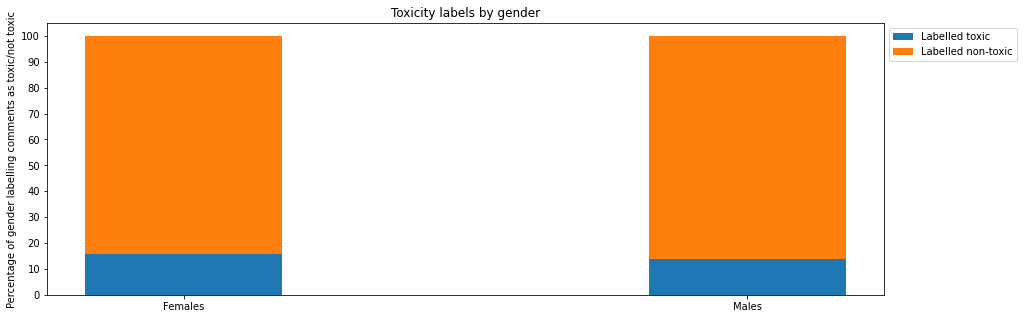

In [169]:
# Documentation for plotting: https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/bar_stacked.html

# Calculating the percentages of males and females likely to label comments as 'toxic'
genders = ['female','male']
gender_percent = percentage_stacked_bar('gender',genders,'toxic')

# Plotting stacked bar graph
N = 2               # number of bars
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(15,5))
p1 = plt.bar(ind, gender_percent[0], width)
p2 = plt.bar(ind, gender_percent[1], width, bottom=gender_percent[0])

# Add formats: labels, ticks
plt.ylabel('Percentage of gender labelling comments as toxic/not toxic')
plt.title('Toxicity labels by gender')
plt.xticks(ind, ('Females','Males'))
plt.yticks(np.arange(0, 105, 10))
plt.legend((p1[0], p2[0]), ('Labelled toxic', 'Labelled non-toxic'),loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.savefig("Visualizations/stacked_bargraph_toxicity_gender.png")
plt.show()

**Stacked bar graph (English as a first language)**

Plotting a Graph to check the percentage of native/non-native English speakers likely to label comments as 'toxic'

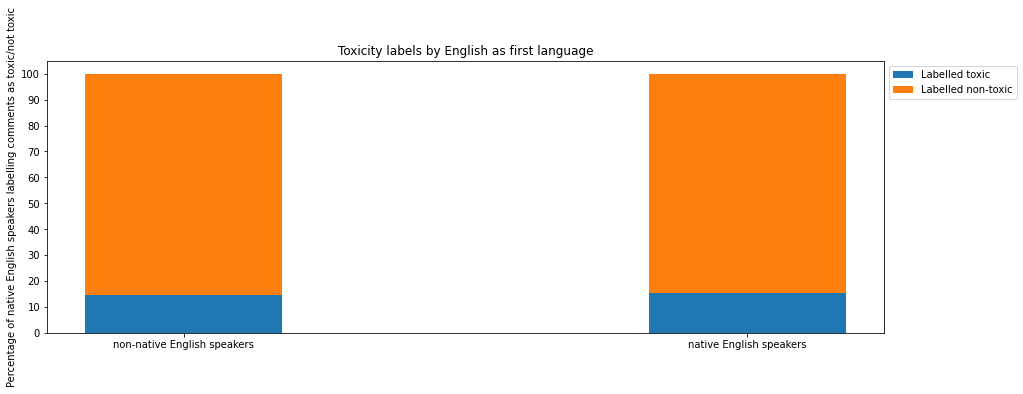

In [170]:
# Calculating the percentages of people with English as a 1st language likely to label comments as 'toxic' 
english_percent = percentage_stacked_bar('english_first_language',[0,1],'toxic')

final_toxic_data['age_group'].unique()

# Plotting stacked bar graph
N = 2               # number of bars
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(15,5))
p1 = plt.bar(ind, english_percent[0], width)
p2 = plt.bar(ind, english_percent[1], width, bottom=english_percent[0])

# Add formats: labels, ticks
plt.ylabel('Percentage of native English speakers labelling comments as toxic/not toxic')
plt.title('Toxicity labels by English as first language')
plt.xticks(ind, ('non-native English speakers','native English speakers'))
plt.yticks(np.arange(0, 105, 10))
plt.legend((p1[0], p2[0]), ('Labelled toxic', 'Labelled non-toxic'),loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.savefig("Visualizations/stacked_bargraph_toxicity_english.png")
plt.show()

**Stacked bar graph (Age)**

Plotting a Graph to check the percentage of people belonging to different age groups likely to label comments as 'toxic'

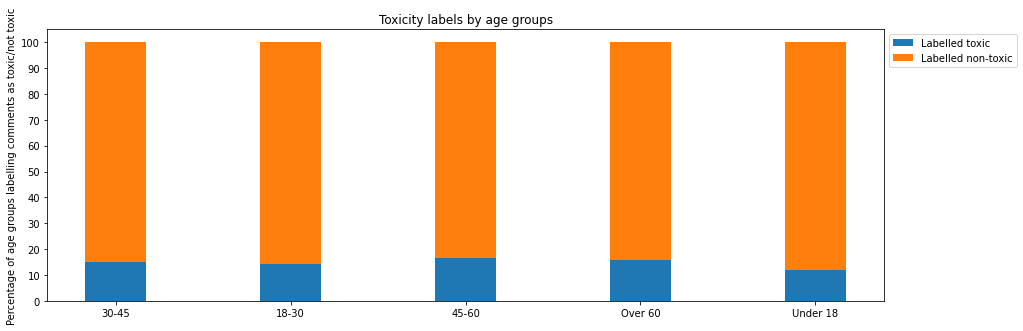

In [171]:
# Calculating the percentages of people with different ages likely to label comments as 'toxic' 
age_groups = ['30-45', '18-30', '45-60', 'Over 60', 'Under 18']
age_percent = percentage_stacked_bar('age_group',age_groups,'toxic')

# Plotting stacked bar graph
N = 5             # number of bars
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(15,5))
p1 = plt.bar(ind, age_percent[0], width)
p2 = plt.bar(ind, age_percent[1], width, bottom=age_percent[0])

# Add formats: labels, ticks
plt.ylabel('Percentage of age groups labelling comments as toxic/not toxic')
plt.title('Toxicity labels by age groups')
plt.xticks(ind, age_groups)
plt.yticks(np.arange(0, 105, 10))
plt.legend((p1[0], p2[0]), ('Labelled toxic', 'Labelled non-toxic'),loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.savefig("Visualizations/stacked_bargraph_toxicity_age.png")
plt.show()

**Stacked bar graph (Education)**

Plotting a Graph to check the percentage of people with different education levels likely to label comments as 'toxic'

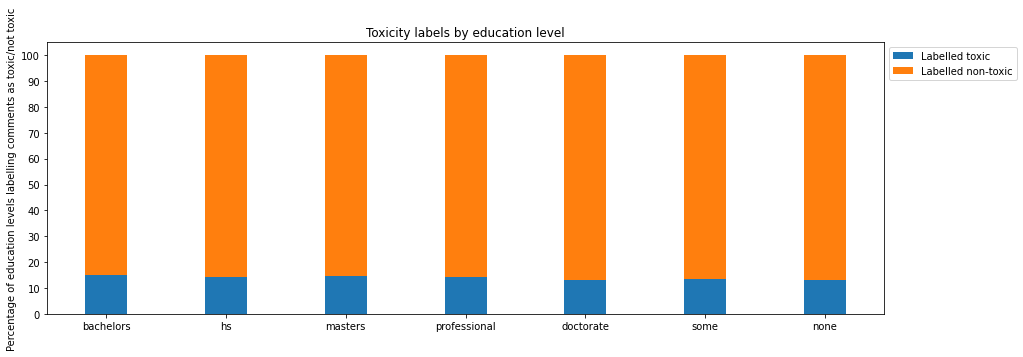

In [172]:
# Calculating the percentages of people with different education as likely to label comments as 'toxic' 
education_groups = ['bachelors', 'hs', 'masters', 'professional', 'doctorate', 'some','none']
education_percent = percentage_stacked_bar('education', education_groups,'toxic')

# Plotting stacked bar graph
N = len(education_groups)             # number of bars
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(15,5))
p1 = plt.bar(ind, education_percent[0], width)
p2 = plt.bar(ind, education_percent[1], width, bottom=education_percent[0])

# Add formats: labels, ticks
plt.ylabel('Percentage of education levels labelling comments as toxic/not toxic')
plt.title('Toxicity labels by education level')
plt.xticks(ind, education_groups)
plt.yticks(np.arange(0, 105, 10))
plt.legend((p1[0], p2[0]), ('Labelled toxic', 'Labelled non-toxic'),loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.savefig("Visualizations/stacked_bargraph_toxicity_eduation.png")
plt.show()

**Toxicity Dataset: Observations**

It is fascinating to see that for all attributes (each group), the data curators have collected data such that roughly the same proportion of annotators have labelled comments as 'toxic' and 'not toxic'. Notably, for each attributes (education, age group, gender, native English speaking), all subgroups have equal representation in the dataset. Moreover, even across all attributes, this representation remains consistent. Roughly, each subgroup that is included marked around 15% of the assigned comments as toxic and about 85% of their comments as non-toxic. This potentially assures us that this possible source of bias has been corrected for by the dataset owners. 

Now, let's see whether the case is the same for the Wikipedia Aggression dataset.

## Wikipedia Aggression dataset: Let's graph for all attributes!

(Attributes: gender, age group, education level, native English speakers)

**Stacked bar graph (Gender)**

Plotting a Graph to check the percentage of males and females likely to label comments as 'aggressive'

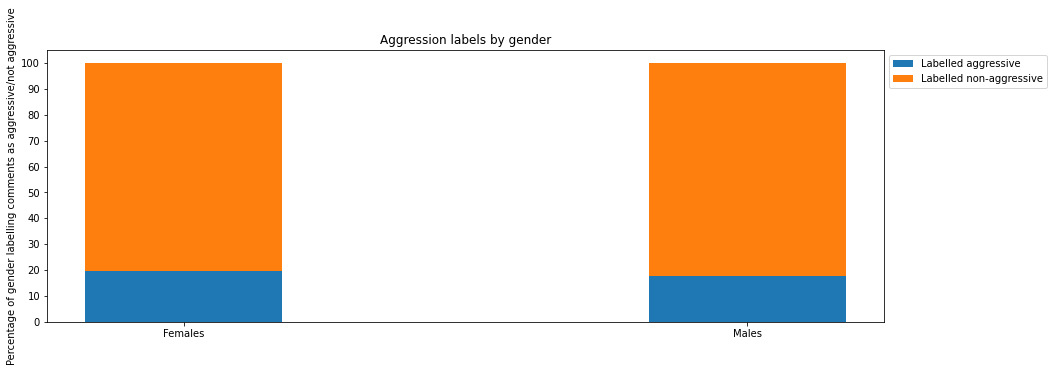

In [173]:
# Documentation for plotting: https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/bar_stacked.html

# Calculating the percentages of males and females likely to label comments as 'toxic'
genders = ['female','male']
gender_percent = percentage_stacked_bar('gender',genders,'aggression')

# Plotting stacked bar graph
N = 2               # number of bars
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(15,5))
p1 = plt.bar(ind, gender_percent[0], width)
p2 = plt.bar(ind, gender_percent[1], width, bottom=gender_percent[0])

# Add formats: labels, ticks
plt.ylabel('Percentage of gender labelling comments as aggressive/not aggressive')
plt.title('Aggression labels by gender')
plt.xticks(ind, ('Females','Males'))
plt.yticks(np.arange(0, 105, 10))
plt.legend((p1[0], p2[0]), ('Labelled aggressive', 'Labelled non-aggressive'),loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.savefig("Visualizations/stacked_bargraph_aggression_gender.png")
plt.show()

**Stacked bar graph (English as a first language)**

Plotting a Graph to check the percentage of native/non-native English speakers likely to label comments as 'aggressive'

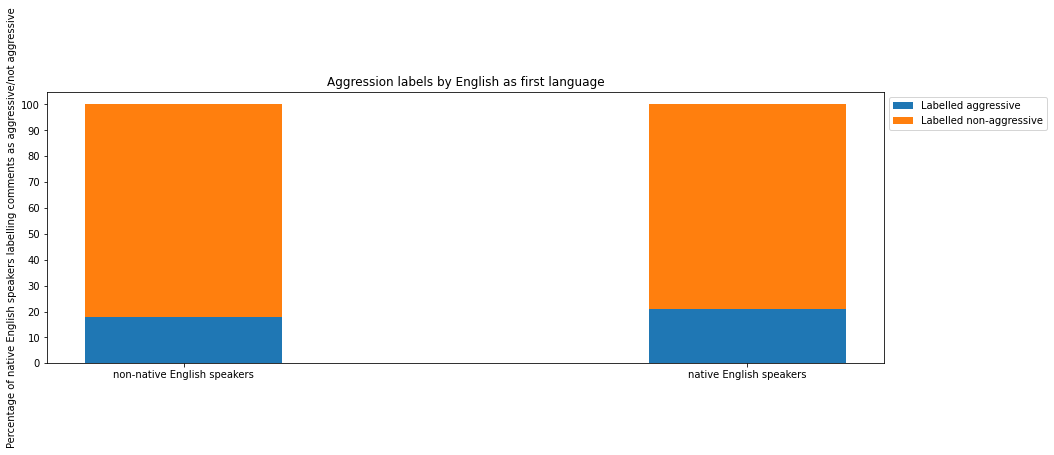

In [174]:
# Calculating the percentages of people with English as a 1st language likely to label comments as 'aggressive' 
english_percent = percentage_stacked_bar('english_first_language',[0,1],'aggressive')

#final_aggression_data['age_group'].unique()

# Plotting stacked bar graph
N = 2               # number of bars
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(15,5))
p1 = plt.bar(ind, english_percent[0], width)
p2 = plt.bar(ind, english_percent[1], width, bottom=english_percent[0])

# Add formats: labels, ticks
plt.ylabel('Percentage of native English speakers labelling comments as aggressive/not aggressive')
plt.title('Aggression labels by English as first language')
plt.xticks(ind, ('non-native English speakers','native English speakers'))
plt.yticks(np.arange(0, 105, 10))
plt.legend((p1[0], p2[0]), ('Labelled aggressive', 'Labelled non-aggressive'),loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.savefig("Visualizations/stacked_bargraph_aggression_english.png")
plt.show()

**Stacked bar graph (Age group)**

Plotting a Graph to check the percentage of different age groups likely to label comments as 'aggressive'

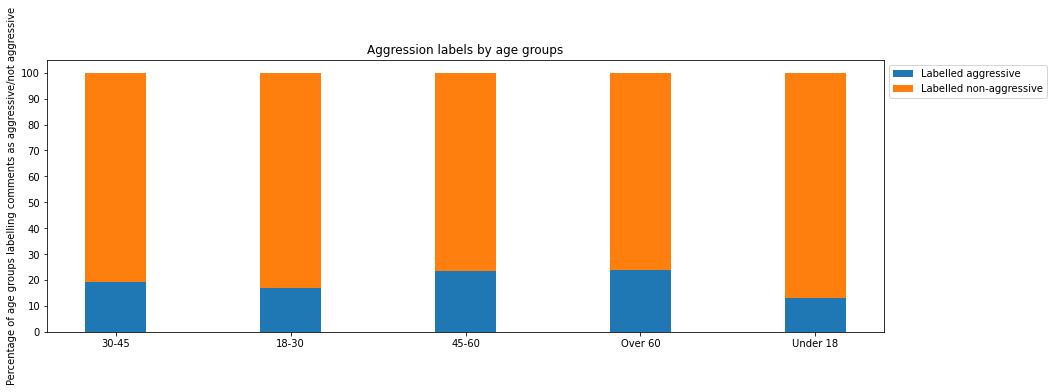

In [175]:
# Calculating the percentages of people with different ages likely to label comments as 'toxic' 
age_groups = ['30-45', '18-30', '45-60', 'Over 60', 'Under 18']
age_percent = percentage_stacked_bar('age_group',age_groups,'aggressive')

# Plotting stacked bar graph
N = 5             # number of bars
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(15,5))
p1 = plt.bar(ind, age_percent[0], width)
p2 = plt.bar(ind, age_percent[1], width, bottom=age_percent[0])

# Add formats: labels, ticks
plt.ylabel('Percentage of age groups labelling comments as aggressive/not aggressive')
plt.title('Aggression labels by age groups')
plt.xticks(ind, age_groups)
plt.yticks(np.arange(0, 105, 10))
plt.legend((p1[0], p2[0]), ('Labelled aggressive', 'Labelled non-aggressive'),loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.savefig("Visualizations/stacked_bargraph_aggression_age.png")
plt.show()

**Stacked bar graph (Education)**

Plotting a Graph to check the percentage of different education levels likely to label comments as 'aggressive'

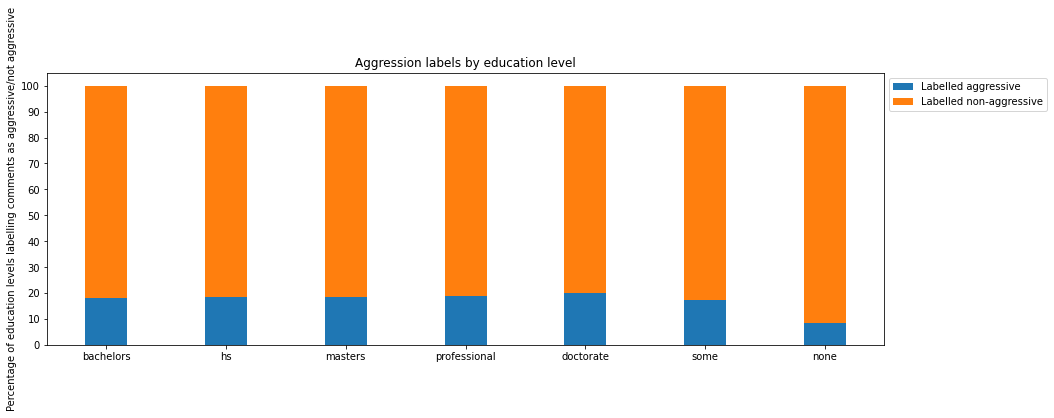

In [176]:
# Calculating the percentages of people with different education as likely to label comments as 'toxic' 
education_groups = ['bachelors', 'hs', 'masters', 'professional', 'doctorate', 'some','none']
education_percent = percentage_stacked_bar('education', education_groups,'aggressive')

# Plotting stacked bar graph
N = len(education_groups)             # number of bars
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(15,5))
p1 = plt.bar(ind, education_percent[0], width)
p2 = plt.bar(ind, education_percent[1], width, bottom=education_percent[0])

# Add formats: labels, ticks
plt.ylabel('Percentage of education levels labelling comments as aggressive/not aggressive')
plt.title('Aggression labels by education level')
plt.xticks(ind, education_groups)
plt.yticks(np.arange(0, 105, 10))
plt.legend((p1[0], p2[0]), ('Labelled aggressive', 'Labelled non-aggressive'),loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.savefig("Visualizations/stacked_bargraph_aggression_education.png")
plt.show()

**Aggression Dataset: Observations**

Wikipedia's aggression labels dataset also tries its best to mitigate potential bias by creating a roughly uniform distribution of 1 and 0 labels across different education, gender, English-speaking and age groups. The distribution is notably less uniform than the toxicity dataset but still does a good job of creating a pretty even spread. 

**Conclusion:**
Overall, both the Wikipedia aggression and toxicity datasets do a good job in trying to mitigate a potential source of bias in the data by creating an equitable distribution of labellers who label 0/1 (toxic/non-toxic, aggressive/non-aggressive) across different attribute groups.

# Analysis 2

The second analysis will be about the bias that may result from disagreements between labellers who annotate the same comment. We will evaluate this by calculating the standard deviations in annotations for each comment. Then we will determine the 100 comments with most standard deviation/disagreement and 100 comments with least standard deviation/disagreement. The reason I use standard deviation instead of variance is because it can be compared to the range (max-min) of the toxicity/aggression scores on the same scale or unit. The question here is:

**Do labellers disagree more about some hostile speech than others (toxic vs aggressive language)? How can we quantify this disagreement and what type of comments invoke disagreements in labellers?**

The following cell calculates disagreement amongst labellers as standard deviation of the toxicity/ aggression scores they assign each comment. These scores range from -2 to 2, where -2 represents the most toxic/aggressive comments and 2 represents the most healthy (non-toxic/non-aggressive) comments.

In [177]:
# Calculate variance/ disagreement with grouping by 'comment' and getting standard deviation of toxicity score & toxicity boolean
toxicity_score_variance = final_toxic_data.groupby('comment')['toxicity_score'].std().reset_index()
toxicity_score_variance = toxicity_score_variance.rename(columns={'toxicity_score':'toxicity_std'})
final_toxic_data = final_toxic_data.merge(toxicity_score_variance, on='comment')
#final_toxic_data.head(2)

# Calculate variance/ disagreement with grouping by 'comment' and getting standard deviation of aggression score & aggression boolean
aggression_score_variance = final_aggression_data.groupby('comment')['aggression_score'].std().reset_index()
aggression_score_variance = aggression_score_variance.rename(columns={'aggression_score':'aggression_std'})
final_aggression_data = final_aggression_data.merge(aggression_score_variance, on='comment')
#final_aggression_data.head(2)

The below cell sorts the dataframes with disagreement/standard deviation values in a descending order to get the comments with most disagreement at the top and comments with most agreement at the bottom.

In [178]:
# Sort in descending order based on standard deviation to find out comments with most and least disagreement in toxicity scores
disagreement_toxic = final_toxic_data.sort_values(['toxicity_std'], ascending=[0])

# Sort in descending order based on standard deviation to find out comments with most and least disagreement in aggression scores
disagreement_aggression = final_aggression_data.sort_values(['aggression_std'], ascending=[0])

In [179]:
#disagreement_aggression.head(1)

This cell prints the maximum and minimum values of standard deviation (disagreement) in both the toxicity and aggression datasets to compare the two.

In [180]:
# Printing the maximum value of standard deviation for the toxicity score
print(f"The maximum standard deviation/disagreement in the toxicity scores was {np.max(disagreement_toxic['toxicity_std'])}. This was for the following comment:") 
print(f"{disagreement_toxic[disagreement_toxic['toxicity_std']==np.max(disagreement_toxic['toxicity_std'])]['comment'].unique()[0]}")
print()

# Printing the minimum value of standard deviation for the toxicity score
print(f"The minimum standard deviation/disagreement in the toxicity scores was {np.min(disagreement_toxic['toxicity_std'])}. This was for the following comment:") 
print(f"{disagreement_toxic[disagreement_toxic['toxicity_std']==np.min(disagreement_toxic['toxicity_std'])]['comment'].unique()[0]}")
print()

# Printing the average value of standard deviation for the toxicity score
print(f"The average standard deviation/disagreement in the toxicity scores was {np.average(disagreement_toxic['toxicity_std'])}.") 
print()

# Printing the maximum value of standard deviation for the aggression score
print(f"The maximum standard deviation/disagreement in the aggression scores was {np.max(disagreement_aggression['aggression_std'])}. This was for the following comment:") 
print(f"{disagreement_aggression[disagreement_aggression['aggression_std']==np.max(disagreement_aggression['aggression_std'])]['comment'].unique()[0]}")
print()

# Printing the minimum value of standard deviation for the aggression score
print(f"The minimum standard deviation/disagreement in the aggression scores was {np.min(disagreement_aggression['aggression_std'])}. This was for the following comment:") 
print(f"{disagreement_aggression[disagreement_aggression['aggression_std']==np.min(disagreement_aggression['aggression_std'])]['comment'].unique()[0]}")
print()

# Printing the average value of standard deviation for the aggression score
print(f"The average standard deviation/disagreement in the aggression scores was {np.average(disagreement_aggression['aggression_std'].dropna())}.") 
print()

The maximum standard deviation/disagreement in the toxicity scores was 1.7888543819998317. This was for the following comment:
  I appreciate your assistance Dave  Ill go take a look at your suggestions now  

The minimum standard deviation/disagreement in the toxicity scores was 0.0. This was for the following comment:
  Showcase TV has now been launched according to Sky Digital on Channel 199  

The average standard deviation/disagreement in the toxicity scores was 0.5767319383429047.

The maximum standard deviation/disagreement in the aggression scores was 3.5355339059327378. This was for the following comment:
   Sorry About Vandalism Sorry SorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySorrySo

**Toxicity:**
For the toxicity dataset, the maximum standard deviation in the dataset was 1.78. Compared to the range (-2 to 2 -> range is 4), this is not too high. The comment that caused this standard deviation seems quite innocuous however we might be missing some crucial context. 

The minimum standard deviation was 0.0 implying total agreement. The comment is a 'thank you' and thus, can be unequivocally classified as not toxic.

**Aggression:**
For the aggression dataset, the maximum standard deviation in the dataset was 3.53. This standard deviation is quite high compared to the range. The comment that caused this variance seems to talk apologetically about vandalism and then proceed to vandalize the comment space by adding a very long string with 'sorry' appended extensively.

The minimum standard deviation was 0.0 implying total agreement. The is a neutral comment and thus, can be unequivocally classified as not aggressive.

The cell below creates a histogram of the standard deviation or disagreements about toxicity scores. I'm doing this to check if there is consistency or a pattern in disagreement about labels. This makes it easier to control for bias.

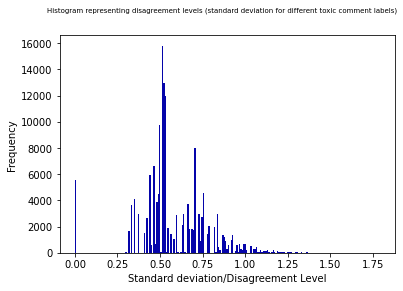

In [181]:
fig, axs = plt.subplots(1, 1, sharey=True)
fig.suptitle('Histogram representing disagreement levels (standard deviation for different toxic comment labels)', fontsize=7)
image = axs.hist(toxicity_score_variance['toxicity_std'].dropna(), bins='auto', color='#0504aa')
plt.xlabel('Standard deviation/Disagreement Level')
plt.ylabel('Frequency')
plt.savefig("Visualizations/histogram_disagreement_toxic.png")

**Observations:**

As we observe from the histogram above, for the toxicity dataset, the standard deviation of labellings by different annotators ranges from 0.0 (indicating complete agreement) upto 1.78 (indicating maximum disagreement in toxicity dataset) which is pretty reasonable considering the toxicity can be labelled from -2 to 2, creating a range of 4. The histogram above shows that the spread of standard deviation is quite uneven. It could possibly be classified loosely as a normal distribution. However, for the most part, it is uneven. This indicates that the disagreement between crowdworkers about labels or toxicity scores could be unpredictable and definitely indicates a potential source of bias in the data. 

Now let's check the equivalent histogram for different aggression comment examples. 

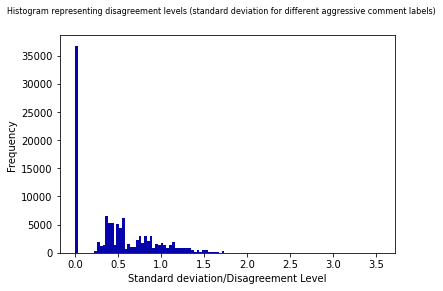

In [182]:
fig, axs = plt.subplots(1, 1, sharey=True)
fig.suptitle('Histogram representing disagreement levels (standard deviation for different aggressive comment labels)', fontsize=8)
image = axs.hist(aggression_score_variance['aggression_std'].dropna(), bins='auto', color='#0504aa')
plt.xlabel('Standard deviation/Disagreement Level')
plt.ylabel('Frequency')
plt.savefig("Visualizations/histogram_disagreement_aggression.png")

**Observations:**

As we observe from the histogram above, for the aggression dataset, the standard deviation of labellings by different annotators ranges from 0.0 (indicating complete agreement) upto 3.53 (indicating maximum disagreement in aggression dataset) which is pretty large considering the aggression can be labelled from -2 to 2, creating a range of 4. We see that the histogram above shows that the spread of standard deviation is still quite uneven but could be construed to resemble a potentially skewed left normal distribution. 

**Comparisons:**
We can see that the average disagreement in the toxicity dataset is much less than the average disagreement in the aggression dataset. So it would seem that toxic comments are less disagreed on than aggressive comments. Although this might be susceptible to extreme outliers and generally sarcastic, confusing comments that could potentially mislead non-native English speakers. 

We can take this analysis a step further and see what types of comments invoke agreement versus disagreement in crowdworkers. We can do this by visualizing what these comments look like in the form of a word cloud to look at the language frequently used in comments causing disagreement/agreement.

Let's start by talking about toxic comments.

In [183]:
# We can filter the most disagreement causing and agreement causing toxic comments
most_disagreed_toxic = disagreement_toxic.head(1000)
most_agreed_toxic = disagreement_toxic.tail(1000)
# Filter it to the unique set of comments
most_disagreed_toxic = list(set(most_disagreed_toxic['comment']))
most_agreed_toxic = list(set(most_agreed_toxic['comment']))

# We can filter the most disagreement causing and agreement causing aggressive comments
most_disagreed_aggression = disagreement_aggression.head(1000)
most_agreed_aggression = disagreement_aggression.tail(1000)
# Filter it to the unique set of comments
most_disagreed_aggression = list(set(most_disagreed_aggression['comment']))
most_agreed_aggression = list(set(most_agreed_aggression['comment']))

The cell below is for downloading stopwords to filter them out during visualization

In [184]:
nltk.download("stopwords")
stopwords = list(set(stopwords.words('english')))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The below cell is for cleaning the text data. I will remove stopwords and words like 'wikipedia' and 'article' that unnecessarily overload the term frequency in these comments.

**Most agreed toxic dataset comments**

In [185]:
# Remove trailing whitespaces from the left and right
most_agreed_toxic = list(map(lambda a: a.strip(), most_agreed_toxic))
# Use tokenizer for tokenizing all words
tokenizer = RegexpTokenizer(r'\w+')
most_agreed_toxic = list(map(lambda a: tokenizer.tokenize(a.lower()), most_agreed_toxic))
most_agreed_toxic = list(map(lambda a: [item for item in a if item not in stopwords], most_agreed_toxic))
# drop 'article' and 'wikipedia'
most_agreed_toxic = list(map(lambda a: [item for item in a if item not in ['wikipedia','article']], most_agreed_toxic))

In [186]:
# Joining the text for most agreed toxic labelled comments for word cloud visualization
text = []
for comment in most_agreed_toxic:
  temp = " ".join(comment)
  text.append(temp)
text = " ".join(text)
#text

***Visualizing the comments in the 'Toxic' dataset with most agreed upon labels***

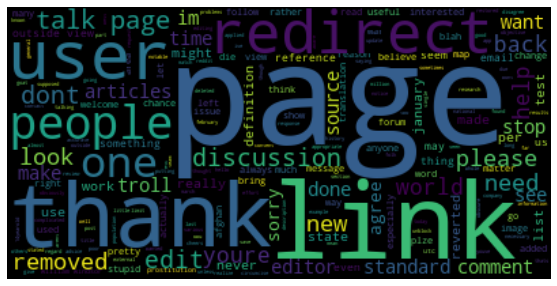

In [187]:
wordcloud = WordCloud().generate(text)
# Display the generated image:
plt.figure(figsize=(15,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('Visualizations/wordcloud_toxic_agreements.png')

**Observations**: We can see that this word cloud is mostly filled with relatively neutral words. The main words are pretty dull and comments containing these words are largely agreed upon by labellers in terms of toxicity.

Now, let's explore the word cloud visualization for the most disagreed upon comments in the 'Toxicity' dataset.

**Most disagreed upon toxic dataset comments:**

In [188]:
# Removing trailing whitespaces from comments
most_disagreed_toxic = list(map(lambda a: a.strip(), most_disagreed_toxic))
# Creating a tokenizer for regexp tokenization of comments
tokenizer = RegexpTokenizer(r'\w+')
most_disagreed_toxic = list(map(lambda a: tokenizer.tokenize(a.lower()), most_disagreed_toxic))
most_disagreed_toxic = list(map(lambda a: [item for item in a if item not in stopwords], most_disagreed_toxic))
# drop 'article' and 'wikipedia'
most_disagreed_toxic = list(map(lambda a: [item for item in a if item not in ['wikipedia','article']], most_disagreed_toxic))

In [189]:
# Creating a string with tokens from most disagreed labelled comments for visualization
text = []
for comment in most_disagreed_toxic:
  temp = " ".join(comment)
  text.append(temp)
text = " ".join(text)

***Visualizing the comments in the 'Toxic' dataset with most disagreed upon labels***

In [190]:
wordcloud = WordCloud().generate(text)

# Display the generated image:
# This plot may have some swear words, uncomment the lines below if you want to see visualization
#plt.figure(figsize=(15,5))
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")
#plt.show()
wordcloud.to_file('Visualizations/wordcloud_toxic_disagreements.png')

**Observations:**
The word cloud visualization above contained some more extreme language with cuss words. This could indicate that people disagree more about the toxicity of swear words than neutral words. The visual has been saved in the repository but excluded from the notebook because of the explicit content. One can uncomment the commented lines to recreate the visualization in the notebook.

Now, let's move on to visualizing the aggression dataset. 

**Most agreed aggressive dataset comments:**

In [191]:
# Remove trailing whitespaces from the left and right
most_agreed_aggression = list(map(lambda a: a.strip(), most_agreed_aggression))
# Use tokenizer for tokenizing all words
tokenizer = RegexpTokenizer(r'\w+')
most_agreed_aggression = list(map(lambda a: tokenizer.tokenize(a.lower()), most_agreed_aggression))
most_agreed_aggression = list(map(lambda a: [item for item in a if item not in stopwords], most_agreed_aggression))
# drop 'article' and 'wikipedia'
most_agreed_aggression = list(map(lambda a: [item for item in a if item not in ['wikipedia','article']], most_agreed_aggression))

In [192]:
# Joining the text for most agreed toxic labelled comments for word cloud visualization
text = []
for comment in most_agreed_aggression:
  temp = " ".join(comment)
  text.append(temp)
text = " ".join(text)
#text

***Visualizing the comments in the 'Aggression' dataset with most agreed upon labels***

In [193]:
wordcloud = WordCloud().generate(text)
# Display the generated image:

# WARNING: some of the words might be explicit
# Uncomment the comments below to recreate word cloud

#plt.figure(figsize=(15,5))
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")
#plt.show()
wordcloud.to_file('Visualizations/wordcloud_aggression_agreements.png')

**Observations:**
This word cloud was of the tokens in most agreed upon aggressive comments. As one would expect from a dataset on talk aggression, the comments had some explicit language in them. It would make sense that for such comments, the labellers agreed upon higher aggression scores.

Now, let's move onto the word cloud visualization of the aggressive comments that were least agreed upon.

**Most disagreed upon aggressive dataset comments:**

In [194]:
# Removing trailing whitespaces from comments
most_disagreed_aggression = list(map(lambda a: a.strip(), most_disagreed_aggression))
# Creating a tokenizer for regexp tokenization of comments
tokenizer = RegexpTokenizer(r'\w+')
most_disagreed_aggression = list(map(lambda a: tokenizer.tokenize(a.lower()), most_disagreed_aggression))
most_disagreed_aggression = list(map(lambda a: [item for item in a if item not in stopwords], most_disagreed_aggression))
# drop 'article' and 'wikipedia'
most_disagreed_aggression = list(map(lambda a: [item for item in a if item not in ['wikipedia','article']], most_disagreed_aggression))

In [195]:
# Creating a string with tokens from most disagreed labelled comments for visualization
text = []
for comment in most_disagreed_aggression:
  temp = " ".join(comment)
  text.append(temp)
text = " ".join(text)

***Visualizing the comments in the 'Aggression' dataset with most disagreed upon labels***

In [196]:
wordcloud = WordCloud().generate(text)
# Display the generated image:

# WARNING: some of the words might be offensive
# Uncomment the comments below to recreate word cloud

#plt.figure(figsize=(15,5))
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")
#plt.show()
wordcloud.to_file('Visualizations/wordcloud_aggression_disagreements.png')

**Observations:**
The wordcloud which visualizes comments that are most disagreed upon by labellers also contains explicit and offensive language. One can uncomment the code to have a look at the visualization. 

**Comparisons:**
The wordclouds for the toxicity dataset is overall much tamer and more neutral in terms of language than the aggression dataset. The aggression dataset contains more offensive language in both the 'agreed upon' and 'disagreed upon' labels. The toxic dataset contains some offensive words in the 'disagreed upon' section. 

Most of the visualizations are commented out as part of human-centered design. They can be recreated by uncommenting the code, and also found on the repository. 

# Analysis 3: Bonus!
The final analysis will be regarding bias resulting from the potential lack of demographic parity. ([Refer here for an interesting read](https://towardsdatascience.com/identifying-and-correcting-label-bias-in-machine-learning-ed177d30349e)).
The population distribution of the labellers should be representative of the general population for minimum bias.
Thus stems Question 3:

**Is the population of labellers representative of the world’s population?**

For this analysis, we will require external data to compare the ratio of levels of education, age groups, gender, and population with English as a first language. The data will be taken for the year 2007 as this was when the Wikipedia dataset was posted. So, assuming that the labellers annotated the data in 2007, I will try my best to compare the world population distribution from that year. However, for most attributes, this was not possible. 

The best way to visualize populations (in this case, labellers) as a percentage of a whole, would be with a pie chart.

**Visualizing populations as a function of attributes (gender, age groups, native English speakers, education levels)**

**Population distribution by gender: Toxicity dataset**

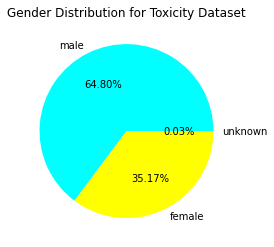

In [197]:
# Setting colors for all pie charts
colors = ['cyan','yellow','orange', 'pink', 'lime']

# Visualizing population distribution by gender
labels = ['male', 'female', 'unknown']
plt.pie(toxic_workers['gender'].value_counts(), labels = labels, colors= colors, autopct='%1.2f%%')
plt.title('Gender Distribution for Toxicity Dataset')
plt.savefig('Visualizations/pie_gender_toxicity.png')
plt.show()

**Population distribution by gender: Aggression dataset**

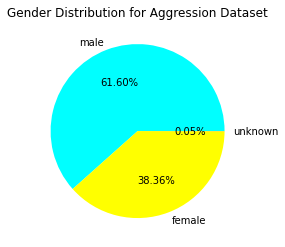

In [198]:
# Visualizing population distribution by gender
labels = ['male', 'female', 'unknown']
plt.pie(aggression_workers['gender'].value_counts(), labels = labels, colors= colors, autopct='%1.2f%%')
plt.title('Gender Distribution for Aggression Dataset')
plt.savefig('Visualizations/pie_gender_aggression.png')
plt.show()

**Analysis:** The gender ratio as seen above is highly imbalanced. In 2007, according to [this source](https://ourworldindata.org/gender-ratio), we can tell that the percentage of females was approximately 49.6% of the world. In both the above graphs, the female population is highly underrepresented and may be a major cause for bias in data. This goes for both the Wikipedia toxicity and aggression datasets. There was also no information available for people who fall in the non-binary conforming category. Now, let's explore another feature.

**Population distribution by native English speaking:**

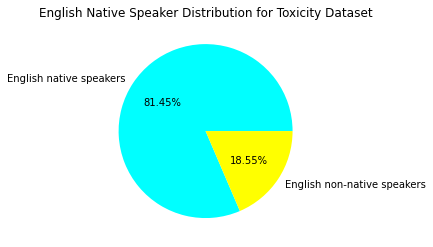

In [199]:
# Visualizing population distribution by English speakers
labels = ['English native speakers', 'English non-native speakers']
plt.pie(toxic_workers['english_first_language'].value_counts(), labels = labels, colors= colors, autopct='%1.2f%%')
plt.title('English Native Speaker Distribution for Toxicity Dataset')
plt.savefig('Visualizations/pie_english_toxicity.png')
plt.show()

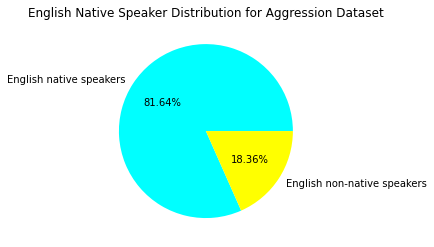

In [200]:
# Visualizing population distribution by English speakers
labels = ['English native speakers', 'English non-native speakers']
plt.pie(aggression_workers['english_first_language'].value_counts(), labels = labels, colors= colors, autopct='%1.2f%%')
plt.title('English Native Speaker Distribution for Aggression Dataset')
plt.savefig('Visualizations/pie_english_aggression.png')
plt.show()

**Analysis:** According to [this website](https://lemongrad.com/english-language-statistics/), there are about 378 million native English speakers and 743 million non-native speakers. This means, of all the English-speaking population, roughly 2/3 (or 67%) speak English as non-native speakers and around 33% speak English as a first language. The above graphs show a much larger percentage of English native speakers than non-native speakers, making this again a possible source of bias in the data. Now, onto exploring age groups!

**Population distribution by age group:**

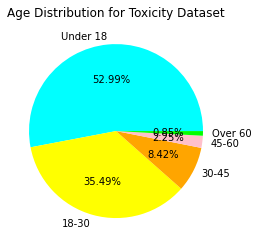

In [201]:
# Visualizing population distribution by age group
labels = ['Under 18','18-30', '30-45', '45-60', 'Over 60']
plt.pie(toxic_workers['age_group'].value_counts(), labels = labels, colors= colors, autopct='%1.2f%%')
plt.title('Age Distribution for Toxicity Dataset')
plt.savefig('Visualizations/pie_age_toxicity.png')
plt.show()

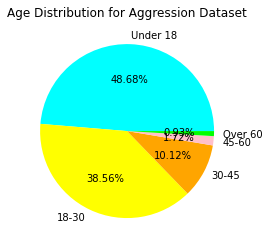

In [202]:
# Visualizing population distribution by age group
labels = ['Under 18','18-30', '30-45', '45-60', 'Over 60']
plt.pie(aggression_workers['age_group'].value_counts(), labels = labels, colors= colors, autopct='%1.2f%%')
plt.title('Age Distribution for Aggression Dataset')
plt.savefig('Visualizations/pie_age_aggression.png')
plt.show()

**Analysis:**
The closest resource I could find to a distribution of age groups similar to the Wikipedia dataset was [this image](https://www.researchgate.net/figure/Pie-chart-showing-distribution-of-age_fig1_261761737). However, due to differences in encodings, this was a tedious task. From the above graphs, we can observe that the under 18 category is grossly overrepresented in the Wikipedia dataset. The under 20 category in the Researchgate image is just about 12% of the population. The 21-30 years category dominates the Researchgate image with about 56% whereas here it seems to be around 39%, barring some overlap. The takeaway however is that high school goers (under 18) seem to dominate the Wikipedia annotators dataset and may hence again be a source of bias in data as they do not represent the entirety of the population, assuming that the Researchgate article is accurate.

**Population distribution by education:**

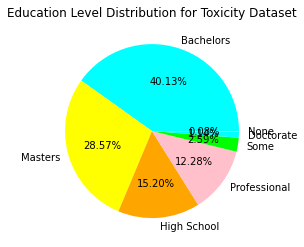

In [203]:
# Visualizing population distribution by age group
labels = ['Bachelors', 'Masters', 'High School', 'Professional', 'Some', 'Doctorate', 'None']
plt.pie(toxic_workers['education'].value_counts(), labels = labels, colors= colors, autopct='%1.2f%%')
plt.title('Education Level Distribution for Toxicity Dataset')
plt.savefig('Visualizations/pie_education_toxicity.png')
plt.show()

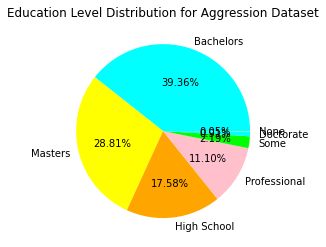

In [204]:
# Visualizing population distribution by age group
labels = ['Bachelors', 'Masters', 'High School', 'Professional', 'Some', 'Doctorate', 'None']
plt.pie(aggression_workers['education'].value_counts(), labels = labels, colors= colors, autopct='%1.2f%%')
plt.title('Education Level Distribution for Aggression Dataset')
plt.savefig('Visualizations/pie_education_aggression.png')
plt.show()

**Analysis:**
This category had the least data on the Internet. It is very specifically encoded, making it very difficult to match with other datasets. Thus, I cannot say with full confidence whether it is indeed representative of the world population or not. 

**Conclusion:**

Out of 4 categories/ attributes provided about the crowdworkers, 3 of these attributes had a spread that is unrepresentative of the population as a whole. **This is a huge gaping hole in the dataset and can definitely contribute to biased labellings**. The Toxicity and Aggression datasets are quite comparable because the pie charts are very similar across all attributes for both datasets. The distribution across different attributes are fairly equal.

# Step 2: Discuss further implications for research and product development

[Perspective API Wiki](https://github.com/conversationai/perspectiveapi/wiki/perspective-hacks)

1. Which, if any, of these demo applications would you expect the Perspective API—or any model trained on the Wikipedia Talk corpus—to perform well in? Why?

The Hot Topics demo applications seems like a very useful tool and is something that is feasible and the Wikipedia Talk corpus would perform well in. It would be a matter of taking each dataset (toxicity, aggression or personal attacks) and identifying key words for each comment and the ratings it was ascribed to by annotators. Comments with similar key words (or word embeddings that were close to already annotated key words/comments) can be moderated depending on the ratings such comments have been previously ascribed. This seems like a perfectly good application for the Wikipedia Talk corpus that would work quite well despite existing sources of bias.

2. Which, if any, of these demo applications would you expect the Perspective API to perform poorly in? Why?

The Toxicity Timeline application seems like something the Perspective API might perform poorly in. Over time, language and the way it's used changes. The nuances of language, slang, internet abbreviations keep changing. The Perspective API needs to change in keeping with these trends in order for the Toxicity Timeline to work properly. However, at any point in time, the API will only work on pre-existing labelled data. So the model is less likely to be trained on currently occuring trends. This is a major drawback in the Toxicity Timeline that needs to be addressed.

3. What are some other contexts or applications where you would expect the Perspective API to perform particularly well, or particularly poorly? Why?

Currently the Perspective API is trained only on English Wikipedia. If it was repurposed to perform operations on any other low-resource language oriented Wikipedia, it would perform particularly poorly. It could perform extra well when employed in countries that have a larger native English speaking population. We see that the dataset is biased towards native English speakers as a greater percentage of the labellers are native English speakers than the native English speaker percentage in the world. So, if we apply the trained models to largely English speaking populations, it may perform exceedingly well. We also saw that the dataset or crowdworkers are biased towards males and people under the age of 18, as larger percentages of the crowdworkers belong to these groups. So, when applied to scenarios where these specific groups dominate the population, the model could perform particularly well.

What are some kinds of hostile speech that would be difficult to accurately detect using the approach used to train the Perspective API models? 

4. What are some potential unintended, negative consequences of using the Perspective API for any of these purposes? In your opinion, are these consequences likely or serious enough that you would recommend that the Perspective API not be used in these applications? Why or why not?

A potentially negative consequence of using the Perspective API to filter out toxic comments is the possible infringement on freedom of speech. In situations wherein a comment is wrongly classified as toxic and rated poorly, the model has a real chance of discriminating against certain users for no explainable reason. In these situations, it becomes exceedingly important to have human moderators who are able to introduce a human element to these ML trained models. In such cases, commentors with real insights and a desire to be heard might suffer unrightfully. Even despite controlling and moderating thresholds for false positives, there is a potential for misclassification. Moreover, this would not be just a one-off case of discrimination. At the high rate and volume of incoming comments, even a 1% misclassification error leads to a huge, disproportionate number of filtered comments. Thus, the need for human moderation in filtering these is crucial. Thus, in such situations, I would recommend that the Perspective API not be used, at the very least independently. There needs to be human regulation.

5. Imagine you are one of the Google data scientists who maintains the Perspective API. If you wanted to improve the model or the API itself to make it work better for any of these purposes, how should they go about doing that?

To improve the model or the API, I would first explore the possibility of stratified sampling from the existing dataset. This could help eliminate sources of bias in the data by sampling equally from existing data to match the representative population groups in the real world. As we saw in the dataset, different age, gender and English-speaking groups were either underrepresented or overrepresented, skewing the labellers' population. Additionally, I would collect more data about the annotators to get a better sense of why the model is working the way it is and make it more interpretable. Although additional data would be ideal, I realize it might be overreaching and too much of an ask.
